## P3: Wrangle OpenStreetMap Data
- Neo Xing, 2016/11
- Data using preselected map of Beijing City in China

## Data Preparation
- Download a preselected metro area from [Map Zen](https://mapzen.com/data/metro-extracts/)
- Extract sample data for investigation

In [140]:
import os
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
# utils for data audit and cleaning
from utils import get_sample, process_map

%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = 10, 8

DATA_DIR = os.path.join(os.getcwd(), 'data')

In [40]:
map_url = 'https://s3.amazonaws.com/metro-extracts.mapzen.com/beijing_china.osm.bz2'
map_osm = 'beijing_china.osm'
map_osm_sample = 'beijing_china_sample.osm'

# for sample data
#AUDIT = False
#OSM_PATH = map_osm_sample

# for map data
AUDIT = True
OSM_PATH = map_osm

NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"
DB_PATH = 'map.db'

In [37]:
## prepare map data and sample data
# download data
if not os.path.isdir(DATA_DIR):
    os.mkdir(DATA_DIR)
os.chdir(DATA_DIR)
map_bz2 = map_url.split('/')[-1]
if not os.path.isfile(map_osm):
    print "Map data", map_osm, " not found"
    print "downloading..."
    !wget $map_url
    print "Extracting ..."
    !bzip2 -d $map_bz2

# sampling data
if not os.path.isfile(map_osm_sample):
    print "Creating map sample data ..."
    get_sample(map_osm, map_osm_sample)

# basic statistics
!du -sh *osm

157M	beijing_china.osm
 16M	beijing_china_sample.osm


In [266]:
# overview of `OSM` data
!head $map_osm_sample
!tail $map_osm_sample

<?xml version="1.0" encoding="UTF-8"?>
<osm>
  <node changeset="41734754" id="25248662" lat="39.9059631" lon="116.391248" timestamp="2016-08-27T12:19:21Z" uid="4128818" user="Malvolapukulo" version="85">
		<tag k="admin_level" v="2" />
		<tag k="alt_name:eo" v="Bejĝino" />
		<tag k="alt_name:fr" v="Beijing" />
		<tag k="alt_name:is" v="Peking" />
		<tag k="alt_name:sv" v="Peking" />
		<tag k="capital" v="yes" />
		<tag k="gns:ADM1" v="22" />
		<tag k="type" v="multipolygon" />
	</relation>
	<relation changeset="42018255" id="6574579" timestamp="2016-09-09T06:46:39Z" uid="3683098" user="suze8793686" version="1">
		<member ref="361015039" role="outer" type="way" />
		<member ref="441566018" role="outer" type="way" />
		<tag k="building" v="commercial" />
		<tag k="name" v="科创大厦1" />
		<tag k="type" v="multipolygon" />
	</relation>
	</osm>

## Data Cleaning
- We need to understand the map data before formal audit and cleaning.
- To do that, we first sample the map data to get a small subset, then store it into `csv` for inspection.
- After the problems are identified, the whole map dataset will be processed, auditted and imported into database.

### Parse Map Data
- Thoroughly audit and clean dataset, converting it from `XML` to `CSV` format.
- Then import the cleaned `.csv` files into a `SQL` database using custom schema.

In [38]:
## parse and load map data to csv files
if not os.path.isfile(NODES_PATH):
    process_map(OSM_PATH, validate=True, audit=AUDIT)

!du -sh *csv

 58M	nodes.csv
2.7M	nodes_tags.csv
6.1M	ways.csv
 20M	ways_nodes.csv
7.3M	ways_tags.csv


In [80]:
nodes = pd.read_csv(NODES_PATH)
node_tags = pd.read_csv(NODE_TAGS_PATH)
ways = pd.read_csv(WAYS_PATH)
way_nodes = pd.read_csv(WAY_NODES_PATH)
way_tags = pd.read_csv(WAY_TAGS_PATH)

In [83]:
for df, fn in zip((nodes, node_tags, ways, way_nodes, way_tags),
                  (NODES_PATH, NODE_TAGS_PATH, WAYS_PATH, WAY_NODES_PATH, WAY_TAGS_PATH)):
    print fn
    display(df.head(2))

nodes.csv


,id,lat,lon,user,uid,version,changeset,timestamp
0,25248662,39.905963,116.391248,Malvolapukulo,4128818,85,41734754,2016-08-27T12:19:21Z
1,25248785,39.906190,116.389457,4rch,1772211,12,27570508,2014-12-19T14:33:04Z


nodes_tags.csv


,id,key,value,type
0,25248662,admin_level,2,regular
1,25248662,eo,Bejĝino,alt_name


ways.csv


,id,user,uid,version,changeset,timestamp
0,4231222,hanchao,499500,18,24718546,2014-08-13T08:58:19Z
1,4231223,hanchao,499500,23,24718546,2014-08-13T08:58:19Z


ways_nodes.csv


,id,node_id,position
0,4231222,25248785,0
1,4231222,330841128,1


ways_tags.csv


,id,key,value,type
0,4231222,name,广场西侧路,regular
1,4231222,oneway,yes,regular


### Problems Encountered

- Data `node_tags, way_tags` of sample map has been inspected mostly by mannual to identify errors.
- The following is analysis of error types and strategy for audit and cleaning.
- Data has been validated for **completeness** and **consistency** when written to `csv` files.
- Data `nodes, ways and way_nodes` contains standard values such as `id`, `timestamp` that are generated by machine, and validated when created as `csv` files.



#### Accuracy Error
- Type: error data, marked as **to be fixed**
- Strategy: it will be dropped as it can not be trusted or used
- Example
``` 
#Row     id      key                  value                              type
3114 1942976252	FIXME	estimated position. re-log from GPS next time	regular		
3158 1953735342	FIXME	Or no?	regular		
6393 3363489803	fixme	position of this station may be inaccurate	regular	
```

#### Uniformity Error
- Type: inconsistency of **phone number format**
- Strategy: it will converted to uniformed format `+country_number-phone_number`
- Example
```
6176 3116216486	phone	+86 13681462440	regular		
7293 4253188917	phone	+86-10-84018039	regular			
7078 3809864708	phone	1067112480	regular		
```

- Type: inconsistency of **address format**
- Strategy: abbreviation will be 
- Example
```
1237 33803488	en	S. Yuyuantian Rd	name
1822 42709486	en	Sanlitun East 2nd St	name
1835 42725731	en	Yongding Rd.	name
1872 42746577	en	5th Ring road	name
1230 33681029	en	ANDINGMEN DONGDAJIE	name
```

- Type: inconsistency of **locales** due to multilanguages
- Strategy: unchanged due to lack of general algorithms and application context to decide what information is useful
- Example
```
7311 4264013095	cuisine	beef_bowl;chinese;ramen;breakfast	regular
644 529665397	name	獬豸 Imperial Garden	regular
4034 106615225	name	青河路 (Qīnghé lù)	regular
6723 3574054411	name	6號安檢門	regular		
6727 3574841294	name	21	regular		
7474 4396950489	name	자금성 지나서 지하철 역 가는길	regular
```

- Type: inconsistency of **date/time**
- Strategy: unchanged due to lack of application context, more data keys such as `open_month, open_day, ...` can be added in future
- Example
```
1596 1422005598	opening_hours	Mo-Su 05:00-23:00; Apr 1-Oct 31 05:00-24:00	regular	
3091 1938345234	opening_hours	24/7	regular		
6183 3116216486	opening_hours	10am - 11pm	regular
```


### Audit and Cleaning
- Based on previous investigation, we will audit and clean three types of error in data `node_tags` and `way_tags`.

#### Audit `FIXME`
- Drop elements marked with `key == FIXME` or `key == fixme`

In [28]:
display(node_tags[(node_tags['key']=='fixme') | (node_tags['key']=='FIXME')].head())
#display(way_tags[(way_tags['key']=='fixme') | (way_tags['key']=='FIXME')].head())

,id,key,value,type
727,604778475,FIXME,check ref,regular
970,1037727486,FIXME,Possibly a tower,regular
972,1037750228,FIXME,Possibly a tower,regular
974,1037750257,FIXME,Possibly a tower,regular
978,1037790874,FIXME,Or no?,regular


#### Audit `phone`
- Convert phone numbers to uniformed formats of `+CountryCode-AreaCode-LandLine` or `+CountryCode-CellPhone`.
- Invalid phone number will be marked with prefix `N/A`.

In [29]:
# investigate phone numbers
display(node_tags[node_tags['key']=='phone'].head())
#display(way_tags[way_tags['key']=='phone'].head())

,id,key,value,type
722,600265656,phone,(010)64629112,regular
1589,1422005598,phone,68716285;62555813,regular
6174,3116216486,phone,+86 13681462440,regular
7076,3809864708,phone,01067112480,regular
7291,4253188917,phone,+86-10-84018039,regular


In [30]:
import re

PHONE_CC = '86'
PHONE_AC = '10'
PHONE_LANDLINE = 8

phone_re = re.compile(r'\D*(?P<cc>%s)?\D*(?P<ac>%s|%s)?\D*(?P<lc>\d{8,})' % (PHONE_AC, r'0'+PHONE_AC, PHONE_AC))
    
def format_phonenumber(pn):
    '''
    Return formatted phone number, marked with 'N/A' if it's invalid.
    '''
    result = phone_re.search(pn)
    # invalid
    if not result:
        return 'N/A ' + pn
    lc = result.group('lc')
    nlc = len(lc)
    # invalid
    if nlc < PHONE_LANDLINE:
        return 'N/A ' + pn
    # cell phone, no area code
    elif nlc > PHONE_LANDLINE:
        return '+{}-{}'.format(PHONE_CC, lc)
    # landline, add area code
    else:
        return '+{}-{}{}'.format(PHONE_CC, PHONE_AC, lc)
    
def update_phone(phone):
    '''
    Update phone entry with uniformed format.
    phone can be multiple values concatenated with ';' like `68716285;62555813`
    '''
    return ';'.join([format_phonenumber(pn) for pn in phone.split(';')])

In [31]:
# verify audit of phone
phones = node_tags[node_tags['key']=='phone']['value'].values
for pn in phones:
    print '{:20}{}'.format(pn, update_phone(pn))

(010)64629112       +86-1064629112
68716285;62555813   +86-1068716285;+86-1062555813
+86 13681462440     +86-13681462440
01067112480         +86-1067112480
+86-10-84018039     +86-1084018039
01058757888         +86-1058757888
01067630572         +86-1067630572
01067113100         +86-1067113100
64007868            +86-1064007868


#### Audit `name` and `addr`
- Format the name and address consists of English letters.
- It'll be capitalized first, then any abbreviation will be replaced with words.

In [32]:
mapping = {'Rd':'Road',
          'St':'Street',
          'Str':'Street',
          'E':'East',
          'W':'West',
          'N':'North',
          'S':'South',
          'Ave':'Avenue',
          'Dr':'Drive',
          'Bldg':'Building',
          'Pky':'Parkway'}

# expand abbrevation to inlcude '.'
mapping.update({str(k)+'.':v for k,v in mapping.items()})
# match 'N.' first, then 'N'
addr_keys = sorted(mapping.keys(), reverse=True)
addr_re = re.compile(r'\b(?P<abbre>' + r'|'.join([re.escape(k) for k in addr_keys]) + r')(?:\s+|$)')

def is_abbre_addr(addr):
    return addr_re.match(addr.title()) != None

def update_address(addr):
    # x.group returns 'N. ' for sub, need to mannually add space and then strip
    new_addr = addr_re.sub(lambda x: mapping[x.group('abbre')] + ' ', addr.title())
    return new_addr.strip()

In [33]:
# verify audit of address
#nodes_name = node_tags[(node_tags['type'] == 'addr') & (node_tags['key'] == 'street') | (node_tags['key'] == 'en')]
ways_name = way_tags[(way_tags['type'] == 'addr') & (way_tags['key'] == 'street') | (way_tags['key'] == 'en')]

for addr in ways_name['value'].values:
    if is_abbre_addr(addr):
        print '{:30}{}'.format(addr, update_address(addr))

W. Yunlin Rd                  West Yunlin Road
N. Chaoyang Rd                North Chaoyang Road
N. Xisi 8th Alley             North Xisi 8Th Alley
W. Zhushikou Str              West Zhushikou Street
S. Yuyuantian Rd              South Yuyuantian Road
N. Donghuashi Str             North Donghuashi Street
W. Enji Str                   West Enji Street
E. Yangfandian Rd             East Yangfandian Road
N. Yuetan Str                 North Yuetan Street
E. Caoqiao Rd                 East Caoqiao Road
N. Minzhu Str                 North Minzhu Street
N. Chaoyang Rd                North Chaoyang Road
N. Nongzhanguan Rd            North Nongzhanguan Road
W. Military Museum Rd         West Military Museum Road
N. Chaoyangmen                North Chaoyangmen
E. Xinglong Str               East Xinglong Street
S. Gexin Rd                   South Gexin Road
E. Chongwenmen Str            East Chongwenmen Street
W. Chaoyang Rd                West Chaoyang Road
N. Chaoyang Rd                North Ch

### Create Database
- Apply data convertion, audit, and cleaning to whole map data.
- Create database by importing from `csv` files.

In [44]:
if not os.path.isfile(DB_PATH):
    !sqlite3 $DB_PATH < initdb.sql
!du -sh *db

 81M	map.db


In [122]:
# query tools
def query_data(cursor, query):
    '''Return a tuple of rows, flat rows consist of only one element.'''
    cursor.execute(query)
    rows = []
    while True:
        row = cursor.fetchone()
        if not row:
            break
        if len(row) == 1:
            rows.append(row[0])
        else:
            rows.append(row)
    return rows
def query_df(cursor, query):
    '''Return pandas dataframe of query data.'''
    rows = query_data(cursor, query)
    columns = [t[0] for t in cursor.description]
    df = pd.DataFrame(rows, columns=columns)
    return df

In [89]:
db = sqlite3.connect(DB_PATH)
cur = db.cursor()

In [79]:
# show tables and count
print "Table        Count"
tables = query_data(cur, "SELECT name FROM sqlite_master WHERE type='table'")
for t in tables:
    q = "select count(*) from {};".format(t)
    count = query_data(cur, q)[0]
    print '{:12} {}'.format(t, count)

Table        Count
nodes        741822
nodes_tags   75657
ways         109348
ways_tags    223173
ways_nodes   885409


## Data Exploration
- We will explore map data via answering some questions.

### Map Data
#### 1. What are the popular attributes of nodes and ways?
- Most of the top tags belong to public transportation system, that's true for super city like Beijing.

Top 10 key in table nodes_tags
power highway name public_transport source amenity railway barrier en shop 
Top 10 key in table ways_tags
highway building oneway name layer bridge railway source en lanes 


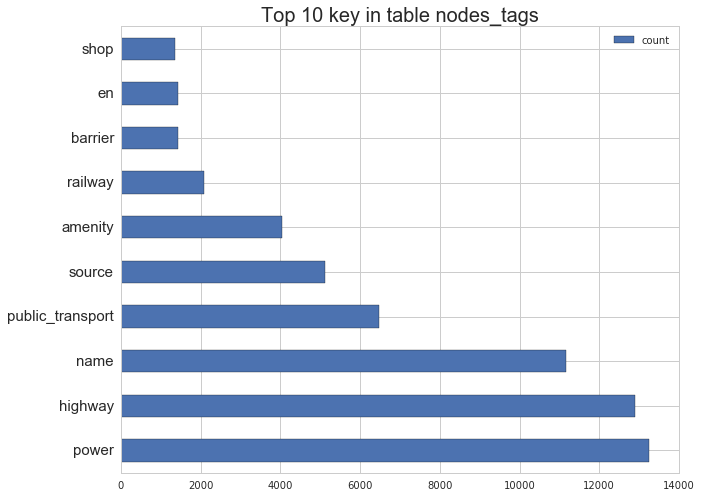

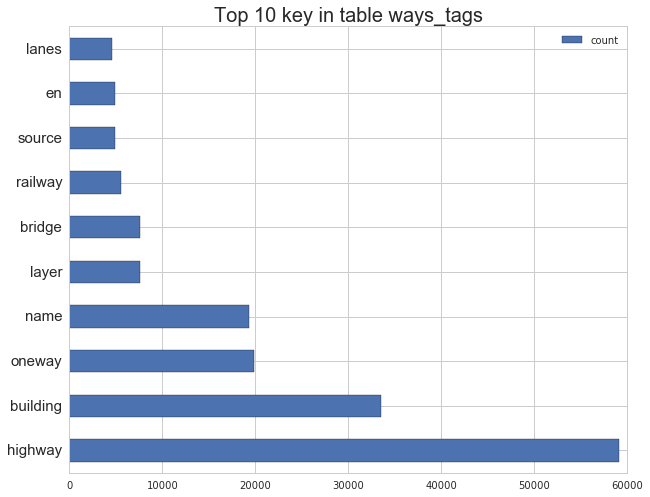

In [195]:
# group by key and then sort by its count
def top_column(cursor, table, key, limit=10):
    q = 'select {}, count(*) as count from {} group by {} order by count(*) desc limit {};'.format(
        key, table, key, limit)
    top = query_df(cur, q)
    title = 'Top {} {} in table {}'.format(limit, key, table)
    ax = top.plot.barh()
    ax.set_title(title, fontsize=20)
    xticks = top[key].str.decode('utf-8')
    ax.set_yticklabels(xticks, rotation='horizontal', fontsize=15)
    #ax.set_ylabel(key, fontsize=15)
    print title
    for k in top[key].values:
        print k,
    print ""
    return top

top_nodes_key = top_column(cur, 'nodes_tags', 'key', 10)
top_ways_key = top_column(cur, 'ways_tags', 'key', 10)

#### 2. What are the most "busy" nodes -- nodes that appear on many roads?
- Most busy nodes are traffic signals on highway, which makes sense.
- Note that 5&6, 7&8 are very close, probably because they belong to the same zone with heavy traffic.
- There are also three nodes that don't have valid entry in nodes_tags.

In [264]:
# first find the top 10 busy nodes by ways_nodes inner join nodes
# then apply left join to add info in nodes_tags
q = '''
select top.*, nodes_tags.value, nodes_tags.key, nodes_tags.type from 
    (select nodes.id, nodes.lat, nodes.lon, count(*) as count
        from ways_nodes 
        left join nodes
        on nodes.id = ways_nodes.node_id
        group by ways_nodes.node_id
        order by count desc
        limit 10) as top
    left join nodes_tags
    on nodes_tags.id = top.id
'''
top_nodes = query_df(cur, q)
print "Top 10 busy nodes by number of ways crossing it"
display(top_nodes)

Top 10 busy nodes by number of ways crossing it


,id,lat,lon,count,value,key,type
0,539259997,39.859272,116.368089,10,None,None,None
1,4134141099,39.520044,116.698067,10,None,None,None
2,331148077,39.931026,116.337912,8,traffic_signals,highway,regular
3,353122271,40.001944,116.559919,8,traffic_signals,highway,regular
4,1056760423,39.871066,116.390171,8,None,None,None
5,76457684,39.922888,116.404614,7,traffic_signals,highway,regular
6,252853378,39.922563,116.367267,7,traffic_signals,highway,regular
7,256832892,40.026129,116.547960,7,traffic_signals,highway,regular
8,292591437,40.020908,116.345900,7,traffic_signals,highway,regular
9,511980200,39.980453,116.359484,7,traffic_signals,highway,regular


#### 3. What are the "longest" ways -- roads that cross most nodes?
- The longest roads are mainly national highways (#1, #3, #8) and tourist trips (#4, #6, #7).
- For simplicity, the definition of longest way is by number of nodes instead of distance.

In [263]:
q = '''
select ways_tags.*, top.count from
    (select id, count(*) as count from
    ways_nodes
    group by ways_nodes.id
    order by count desc
    limit 10) as top
    left join ways_tags
    on ways_tags.id = top.id
    where ways_tags.key='en' or ways_tags.key='name' or ways_tags.type='name'
'''
top_ways = query_df(cur, q)
print "Top 10 longest way by number of nodes"
display(top_ways)

Top 10 longest way by number of nodes


,id,key,value,type,count
0,252721309,name,昌赤路,regular,886
1,325387039,name,109国道,regular,876
2,332284197,name,潭王路,regular,722
3,95513225,name,Y709,regular,706
4,162162040,name,科普探秘游,regular,616
5,210697460,name,红大路,regular,562
6,162527665,name,鹫峰中心景区,regular,495
7,162527633,name,萝芭地景区,regular,488
8,224831843,en,Border Beijing - Hebei,name,473


### Additional Ideas
- Due to limitation of time and resources, the following ideas will be left for future study.

- Visualization on 2-D map is a perfect way to investigate map data, it will enable the geography information and insights that can only be naturally conveyed in 3-D forms.
- For implementation, we could use the help of [The Matplotlib Basemap Toolkit](http://matplotlib.org/basemap/users/examples.html) or [Google Map API](https://developers.google.com/maps/), we will mostly rely on the latitude, longitude, and tags to fetch API and make plots.

#### Benefits
- Visualization on 2-D will enable us to explore the data in flexible and impressive ways, for example
    - Heat map for nodes distribution, traffic intensity (by way crossing)
    - Diagram and coutour of ways that enable navigations.
    - Detailed investigation on 2-D map for various topics, public transportation, tours, public facilities, shopping, etc.

#### Anticipated Problems
- The most possible problem would be conflictiton between OpenStreetMap data and the internal data of map API we use, due to differenc of data quality in either one of them.
- To overcome that, we could combine serveral API or data source to cross validate our data.

## Conclusion
In this report, we investigate a map dataset using various data wrangling methods, such as data audit, data cleaning, and data manupulation in different forms like `XML`, `CSV`, and `SQL`.

The map data shows the importance and challenges of data wrangling. Map data is ready for investigation only after we audit and clean the data for validity, completeness and accuracy.

The distribution of map nodes and ways shows patterns that conform to common sense.